### Data Import
The data is stored in a sqlite database. The package "sqlite3" is used to connect the sqlite db.
pandas is used for manipulating the data in a dataframe format. 
Some of the variable names have spaces and this might create problems in the data preparation phase.
So the spaces are replaced with an underscore. The variable "date" is converted to the "datatime" format to treat
it as date instead of character format

In [1]:
import sqlite3
import pandas as pd

In [2]:
## Please change the path to the location of sqlite database in your pc
path = "C:/Wurth/energydata.sqlite"
con = sqlite3.connect(path)
## Selecting all the rows and columns using SQL Query
energydata = pd.read_sql_query("SELECT * from energydata", con)
energydata.columns = [c.replace(' ', '_') for c in energydata.columns]
energydata["date"]=pd.to_datetime(energydata["date"])
energydata.head()

,Meter_ID,date,Hour,total_hourly_KW
0,1029,2009-07-14,0,0.152
1,1029,2009-07-14,1,0.079
2,1029,2009-07-14,2,0.063
3,1029,2009-07-14,3,0.082
4,1029,2009-07-14,4,0.083


### Data Exploration
The packages "seaborn" and "matplotlib" are used for data visualization. 
numpy is used for manipulating arrays and matrices.
The time series plot shows that the mean hourly consumption increases till reaching a peak in January 2010 and then
decreases till July-August and then starts increasing again reaching a peak towards December. From this plot,
we can infer that the consumption is the highest months of December - January and the lowest towards July - August.
From the mean hourly consumotion chart, we can infer that the consumption is higher in the hours 17 - 20

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

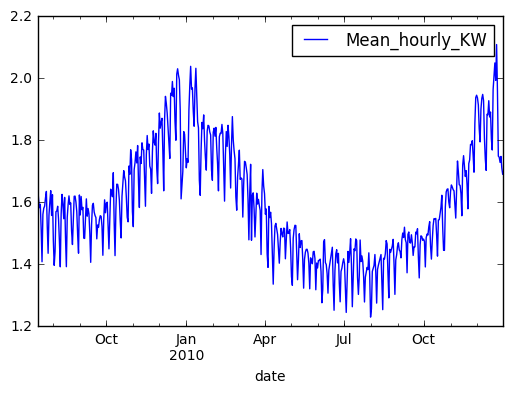

In [4]:
Mean_TimeSeries = pd.DataFrame({'Mean_hourly_KW' : energydata.groupby("date")["total_hourly_KW"].mean()}).reset_index()
Mean_TimeSeries[['date','Mean_hourly_KW']].set_index('date').plot()
plt.show()

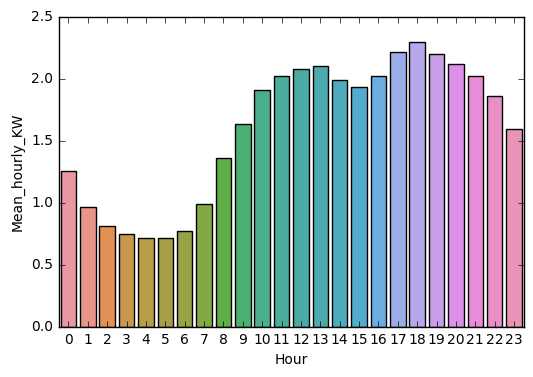

In [5]:
Hourly = pd.DataFrame({'Mean_hourly_KW' : energydata.groupby("Hour")["total_hourly_KW"].mean()}).reset_index()
sns.barplot(x="Hour", y="Mean_hourly_KW", data=Hourly)
plt.show()

### Feature Engineering
For the cluster analysis, the data should be reshaped in the form which contains one row for each user. For this
the total hourly KW should be summarized for each user ID such that each user ID will contain the sum on 
total hourly KW. Two more variables are created - Season and time of day. We have seen from the exploratory 
data analysis that the energy usage follows certain pattern during certain months and hours. The variable Time_of_day is 
created by finding the hour during which each customer(Meter_ID) consumes the most. The maximum consuming hours
are then grouped into 3 categoris - morning(0-8), evening(8-16) and night(16-24). Each customer will belong to
one these categories. Another variable called season is created for representing the maximum consumption period for
each user. Month is extracted from the variable "date". Then the total_hourly_KW is summarized based on Meter_ID and month
The month during which each user consumed the maximum is assigened as the month for each user. The months are then
grouped into four seasons based on the Italian Seasons.
Dummy variable are created for Season and Time_of_day so that they can be fed into the k-means algorithm.

In [6]:
##Extracting the month
energydata['month'] = energydata['date'].dt.month
energydata.head()

,Meter_ID,date,Hour,total_hourly_KW,month
0,1029,2009-07-14,0,0.152,7
1,1029,2009-07-14,1,0.079,7
2,1029,2009-07-14,2,0.063,7
3,1029,2009-07-14,3,0.082,7
4,1029,2009-07-14,4,0.083,7


In [7]:
#Extracting the maximum for each hour for every customer
MeterID_Hour_Max = pd.DataFrame({'total_hourly_KW' : energydata.groupby(["Meter_ID","Hour"])["total_hourly_KW"].max()}).reset_index()
MeterID_Hour_Max.head()

,Meter_ID,Hour,total_hourly_KW
0,1029,0,1.043
1,1029,1,0.334
2,1029,2,0.251
3,1029,3,0.344
4,1029,4,1.336


In [8]:
##Extracting the hour during which maximum consumption occurs
MeterID_Hour_Max = MeterID_Hour_Max.loc[MeterID_Hour_Max.reset_index().groupby(['Meter_ID'])['total_hourly_KW'].idxmax()]
MeterID_Hour_Max.head()

,Meter_ID,Hour,total_hourly_KW
9,1029,9,4.029
37,1036,13,13.035
64,1046,16,11.336
88,1054,16,4.773
116,1055,20,11.927


In [9]:
##Creating the categories - Night, Morning and Evening
MeterID_Hour_Max['Time_of_day'] = np.where((MeterID_Hour_Max['Hour'] >= 0) & (MeterID_Hour_Max['Hour']<8),
                                                             'Night', np.where((MeterID_Hour_Max['Hour'] >= 8) & (MeterID_Hour_Max['Hour']< 16), 
                                                                               'Morning', 'Evening'))

MeterID_Hour_Max.head(10)

,Meter_ID,Hour,total_hourly_KW,Time_of_day
9,1029,9,4.029,Morning
37,1036,13,13.035,Morning
64,1046,16,11.336,Evening
88,1054,16,4.773,Evening
116,1055,20,11.927,Evening
133,1126,13,18.438,Morning
159,1139,15,12.370,Morning
169,1146,1,47.914,Night
199,1147,7,7.775,Night
226,1150,10,10.618,Morning


In [10]:
##Aggreagating and creating the total monthly consumption in the variable Max_monthly_KW
MeterID_Season = pd.DataFrame({'Max_monthly_KW' : energydata.groupby(["Meter_ID","month"])["total_hourly_KW"].sum()}).reset_index()
MeterID_Season.head()

,Meter_ID,month,Max_monthly_KW
0,1029,1,223.333
1,1029,2,181.844
2,1029,3,191.403
3,1029,4,164.514
4,1029,5,170.188


In [11]:
##Finding the month during which the maximum consumption occurs
MeterID_Season = MeterID_Season.loc[MeterID_Season.reset_index().groupby(['Meter_ID'])['Max_monthly_KW'].idxmax()]
MeterID_Season.head()

,Meter_ID,month,Max_monthly_KW
11,1029,12,434.182
23,1036,12,2226.269
35,1046,12,1775.620
47,1054,12,496.128
57,1055,10,1844.487


In [12]:
##Creating the "season" variable by grouping together the maximum consuming months
MeterID_Season['Season'] = np.where((MeterID_Season['month'] >= 3) & (MeterID_Season['month']<6),
                                                             'Spring', np.where((MeterID_Season['month'] >= 6) & (MeterID_Season['month']< 9), 
                                                                               'Summer', np.where((MeterID_Season['month'] >= 9) & (MeterID_Season['month']< 11),
                                                                                                  "Autumn", "Winter")))

MeterID_Season.head(10)

,Meter_ID,month,Max_monthly_KW,Season
11,1029,12,434.182,Winter
23,1036,12,2226.269,Winter
35,1046,12,1775.620,Winter
47,1054,12,496.128,Winter
57,1055,10,1844.487,Autumn
71,1126,12,2481.000,Winter
83,1139,12,3142.464,Winter
95,1146,12,24156.428,Winter
107,1147,12,3729.708,Winter
118,1150,11,1619.532,Winter


In [13]:
##Reshaping our initial dataset making in the format which contains one row per user by summing the total_hourly_KW
energydata = pd.DataFrame({'Total_KW' : energydata.groupby(["Meter_ID"])["total_hourly_KW"].sum()}).reset_index()
energydata.head()

,Meter_ID,Total_KW
0,1029,3186.107
1,1036,10990.694
2,1046,12148.428
3,1054,3473.332
4,1055,13893.583


In [14]:
##Merging the energydata dataset with the other two datasets containing our new features - Season and Time_of_day
energydata = energydata[["Meter_ID", "Total_KW"]].merge(MeterID_Hour_Max[["Meter_ID", "Time_of_day"]], how='left', on='Meter_ID')
energydata = energydata[["Meter_ID", "Total_KW","Time_of_day"]].merge(MeterID_Season[["Meter_ID", "Season"]], how='left', on='Meter_ID')
energydata.head()

,Meter_ID,Total_KW,Time_of_day,Season
0,1029,3186.107,Morning,Winter
1,1036,10990.694,Morning,Winter
2,1046,12148.428,Evening,Winter
3,1054,3473.332,Evening,Winter
4,1055,13893.583,Evening,Autumn


In [15]:
## Creating dummy variables to feed into the clustering algorithm. The clustering algorithm can take only numeric 
## values as input. So if a category is present, we have 1 and if it is absent, we have 0
energydata_clustering = pd.concat([energydata, pd.get_dummies(energydata['Time_of_day']),
                                   pd.get_dummies(energydata['Season'])],axis=1)
energydata_clustering.head()

,Meter_ID,Total_KW,Time_of_day,Season,Evening,Morning,Night,Autumn,Spring,Summer,Winter
0,1029,3186.107,Morning,Winter,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1036,10990.694,Morning,Winter,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1046,12148.428,Evening,Winter,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1054,3473.332,Evening,Winter,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1055,13893.583,Evening,Autumn,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
##Selecting only the required features and discarding the rest
energydata_clustering = energydata_clustering[["Total_KW","Evening", "Morning", "Night",
                                               "Autumn","Spring","Summer","Winter"]]

### Cluster Analysis
We are using the scikit learn library to perform the cluster analysis. To find the best number of clusters, we 
use the elbow method. In this method, we run the k-means algorithm on a range of k values and for each k, we calculate
the sum of squared errors. Then we plot a line chart for each value of k.If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best. The idea is that we want a small SSE, but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster). So our goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k. The data is normalized so that none of the variable will have too much importance

In [17]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [18]:
##Normalizing the data using min- max normalization. z = x-min(x)/max(x)-min(x)
min_max_scaler = preprocessing.MinMaxScaler()
energydata_clustering = min_max_scaler.fit_transform(energydata_clustering)
energydata_clustering = pd.DataFrame(energydata_clustering)
energydata_clustering.head()

,0,1,2,3,4,5,6,7
0,0.008861,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.030657,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.033890,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.009663,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.038764,1.0,0.0,0.0,1.0,0.0,0.0,0.0


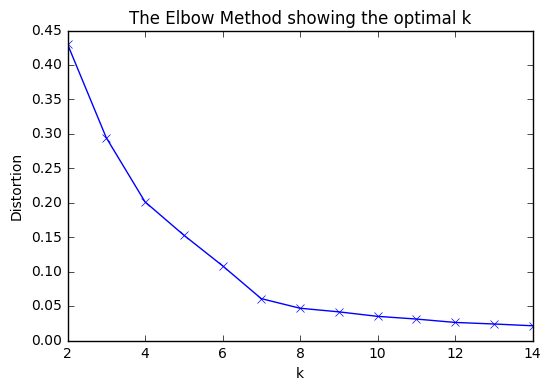

In [19]:
from scipy.spatial.distance import cdist
# k means determine k
distortions = []
K = range(2,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(energydata_clustering)
    kmeanModel.fit(energydata_clustering)
    distortions.append(sum(np.min(cdist(energydata_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / energydata_clustering.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [20]:
##We can see an elbow at the points 4-5 and another at 7-8. The number of segments are chosen keeping in mind the
## business significance. So 4 is chosen as 7 clusters might be a little bit too high
kmeans = KMeans(n_clusters=4,random_state=3000).fit(energydata_clustering)

In [21]:
kmeans.labels_

array([0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 3, 1, 2, 2, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 3, 1, 1, 1, 0, 2, 1, 1, 3, 1, 1, 3, 2, 3, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 2, 1,
       0, 2, 1, 1, 1, 0, 0, 0, 3, 0, 2, 0, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1,
       2, 0, 0, 1, 1, 0, 0, 1, 0, 3, 0, 2, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 3, 1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 3, 3, 1, 1, 3,
       0, 3, 3, 1, 0, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 3, 1, 1,
       1, 0, 0, 0, 1, 2, 0, 1, 3, 0, 1, 0, 0, 0, 0, 1, 1, 1, 3, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 3, 3, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 1, 2, 1, 1, 0, 0, 2, 1, 0, 3, 2, 1, 1,
       0, 0, 0, 0, 3, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 3, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 3, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 2, 3, 2, 1,
       0, 3,

In [22]:
energydata["cluster"] = kmeans.predict(energydata_clustering)
energydata.head(10)

,Meter_ID,Total_KW,Time_of_day,Season,cluster
0,1029,3186.107,Morning,Winter,0
1,1036,10990.694,Morning,Winter,0
2,1046,12148.428,Evening,Winter,1
3,1054,3473.332,Evening,Winter,1
4,1055,13893.583,Evening,Autumn,2
5,1126,11199.452,Morning,Winter,0
6,1139,21908.545,Morning,Winter,0
7,1146,142256.225,Night,Winter,0
8,1147,13599.675,Night,Winter,0
9,1150,12101.308,Morning,Winter,0


In [23]:
energydata.groupby("cluster").size()

cluster
0    183
1    228
2     44
3     45
dtype: int64

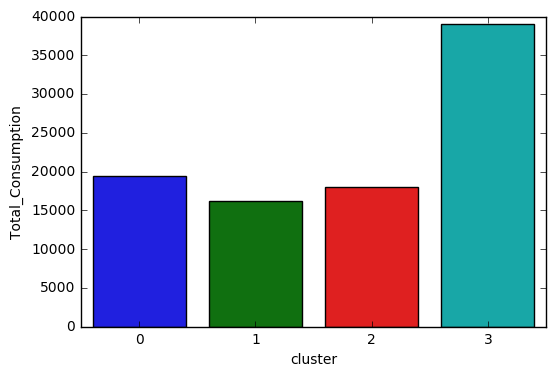

In [24]:
##Plotting the mean consumption per cluster
cluster_consumption = pd.DataFrame({'Total_Consumption' : energydata.groupby(["cluster"])["Total_KW"].mean()}).reset_index()
sns.barplot(x="cluster", y="Total_Consumption", data=cluster_consumption)
plt.show()

In [25]:
##Creating datasets for cluster per season and cluster per time of the day
cluster_season = pd.DataFrame({'Num_Customer' : energydata.groupby(["cluster", "Season"]).size()}).reset_index()
cluster_timeOfDay = pd.DataFrame({'Num_Customer' : energydata.groupby(["cluster", "Time_of_day"]).size()}).reset_index()

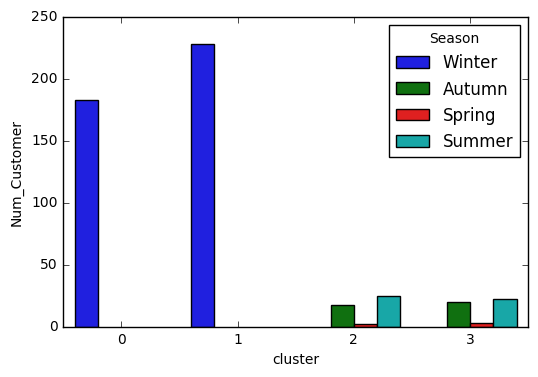

In [26]:
sns.barplot(x="cluster", y="Num_Customer", hue = "Season",data=cluster_season)
plt.show()

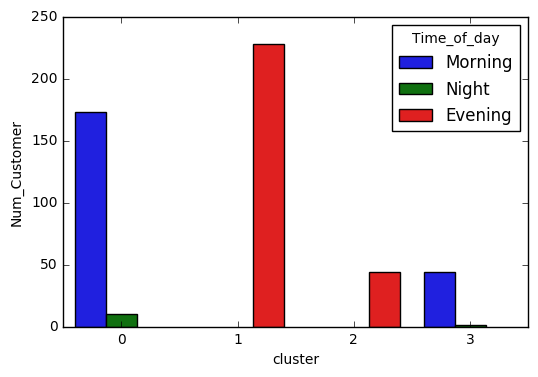

In [27]:
sns.barplot(x="cluster", y="Num_Customer", hue = "Time_of_day",data=cluster_timeOfDay)
plt.show()

### Cluster Description
Four clusters are identified with the characteristics based on energy consumption, Season during which maximum consumption 
occurs and the time of the day during which the maximum consumption occurs.
#### Cluster 0
This is the big cluster which contains about 180 cosumers. They have an average energy consumption and
they consumes mostly during the morning hours in winter season
#### Cluster 1
This is the biggest cluster with more than 220 consumers. They have a comparatively small energy consumption. They also consumes energy during the winter season. They consume energy during the evening hours.
#### Cluster 2
This is a small cluster with less than 50 consumer.They have an average energy consumption and consumes energy during autumn and summer season during the
evening hours of the day
#### Cluster 3
This is also a small cluster with less than 50 consumers. Their average cosumption in much higher(almost twice) than
the other clusters. They consume energy during the morning hours in the autumn and summer season.